In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
kde_raster = '../../Hannah_example/kde_aniso_onlyeruption_mafic.txt'

In [5]:
def get_header_info(asciigrid):
    meta = {}
    with open(asciigrid) as input:
        for i in range(6):
            line = next(input).strip().split()
            meta[line[0]] = line[1]
    return meta

In [6]:
meta = get_header_info(kde_raster)
meta

{'NODATA_value': '-9999.000000',
 'cellsize': '100.000000',
 'ncols': '741',
 'nrows': '901',
 'xllcorner': '544000.000000',
 'yllcorner': '2640000.000000'}

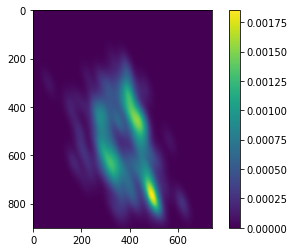

In [8]:
kde = np.loadtxt(kde_raster, skiprows=6)
plt.imshow(kde)
plt.colorbar()

In [34]:
xll = float(meta['xllcorner'])
yll = float(meta['yllcorner'])
cellsize = float(meta['cellsize'])
xur = xll + cellsize * kde.shape[1]
yur = yll + cellsize * kde.shape[0]
xur, yur

(618100.0, 2730100.0)

In [10]:
src_crs = '+init=epsg:32637'
dst_crs = '+init=epsg:4326'

In [11]:
kde.shape

(901, 741)

In [12]:
from rasterio import Affine

In [15]:
trans = Affine(cellsize, 0., xll, 0., -cellsize, yur)

In [16]:
properties = {'count': 1,
              'crs': src_crs,
              'transform': trans,
              'width': kde.shape[1],
              'height': kde.shape[0],
              'driver': 'GTiff',
              'dtype': np.float64,
              'nodata': float(meta['NODATA_value'])}

In [17]:
with rasterio.open('junk/kde_32637.tif', 'w', **properties) as dst:
    dst.write(kde, 1)

In [18]:
with rasterio.open('junk/kde_32637.tif') as src:
    kde2 = src.read(1)
    meta2 = src.meta

In [19]:
plt.imshow(kde2)

In [20]:
meta2

{'count': 1,
 'crs': CRS({'init': 'epsg:32637'}),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 901,
 'nodata': -9999.0,
 'transform': Affine(100.0, 0.0, 544000.0,
       0.0, -100.0, 2730100.0),
 'width': 741}

In [21]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [22]:
xur = xll + cellsize * kde.shape[1]

In [24]:
dst_trans, width, height = calculate_default_transform(src_crs=src_crs,
                                                       dst_crs=dst_crs,
                                                       width=kde.shape[1],
                                                       height=kde.shape[0],
                                                       bottom=yll, left=xll,
                                                       right=xur, top=yur
                                                       )

In [25]:
dst_trans

Affine(0.0009366458176494151, 0.0, 39.43216510373904,
       0.0, -0.0009366458176494151, 24.684650247907)

In [29]:
outprops =   {'count': 1,
              'crs': dst_crs,
              'transform': dst_trans,
              'width': width,
              'height': height,
              'driver': 'GTiff',
              'dtype': np.float64}

In [33]:
src_crs, dst_crs

('+init=epsg:32637', '+init=epsg:4326')

In [30]:
with rasterio.open('junk/kde_32637_ll.tif', 'w', **outprops) as dst:
    reproject(source=kde, 
              destination=rasterio.band(dst, 1),
              src_transform=trans,
              src_crs=src_crs,
              dst_transform=dst_trans,
              dst_crs=dst_crs,
              resampling=Resampling.bilinear
             )

In [32]:
with rasterio.open('junk/kde_32637_ll.tif') as src:
    plt.imshow(src.read(1))

In [31]:
from GISops import project_raster

In [35]:
project_raster('junk/kde_32637.tif', 
               'junk/kde_32637_ll_2.tif', dst_crs=dst_crs)

reprojecting junk/kde_32637.tif...
from:
+init=epsg:32637, res: 1.00e+02, 1.00e+02
to:
+init=epsg:4326, res: 9.37e-04, 9.37e-04...
wrote junk/kde_32637_ll_2.tif.


/Users/aleaf/anaconda/envs/gis/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  from ipykernel import kernelapp as app


In [36]:
top = dst_trans[5]
left = dst_trans[2]
bottom = top + dst_trans[4] * height
right = left + dst_trans[0] * width

In [37]:
import folium
from folium import plugins
import branca.colormap as cm

In [38]:
y, x = np.mean((bottom, top)), np.mean((left, right))
x, y

(39.799798587166435, 24.27580434850303)

In [45]:
m = folium.Map(location=[y, x], zoom_start=10, tiles='Stamen Terrain')
plugins.ImageOverlay(kde, [[bottom, left], 
                           [top, right]],
                    opacity=0.5).add_to(m)
cmap = cm.LinearColormap(['white', 'black'],
                         vmin=kde.min(), vmax=kde.max())
cmap.caption = 'Probability'
m.add_child(cmap)
m.save('junk/kde_map.html')